In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys

In [2]:
# qsub -IVX -l nodes=1:ppn=12,mem=16g,vmem=16g,walltime=04:00:00
import multiprocessing
multiprocessing.cpu_count()

64

In [3]:
# Configuration for the parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=12, threads_per_worker=1, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:46657 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 48.00 GB


In [4]:
client.close()

In [5]:
period = slice('2001-01-01','2001-12-31')
seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/AVHRR_MERGED/v2.0/2001/' # local, first test for only one year
save_data = '/data/mmenegoz/Alpine_snow_2001.nc'
# Alpine domain
latlim_ext,lonlim_ext=slice(44,48), slice(5,17)

In [6]:
%%time
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data)
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data, parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data)

The file /data/mmenegoz/Alpine_snow_2001.nc already exists
CPU times: user 43 ms, sys: 23 ms, total: 66 ms
Wall time: 131 ms


In [27]:
ds_alps.scfg

<xarray.DataArray 'scfg' (time: 365, lat: 80, lon: 240)>
dask.array<open_dataset-9889d7e43c9dbf521581c6b3da0ac8bdscfg, shape=(365, 80, 240), dtype=float32, chunksize=(365, 80, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 44.03 44.08 44.12 44.17 ... 47.83 47.88 47.92 47.97
  * lon      (lon) float64 5.025 5.075 5.125 5.175 ... 16.83 16.88 16.92 16.98
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [210 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [8]:
# scf is the data get after replacing cloud and water gridcells with missing values
scf = ds_alps.scfg.where(ds_alps.scfg <= 100).load()
# scf

/home/mmenegoz/.conda/envs/martin_2021/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


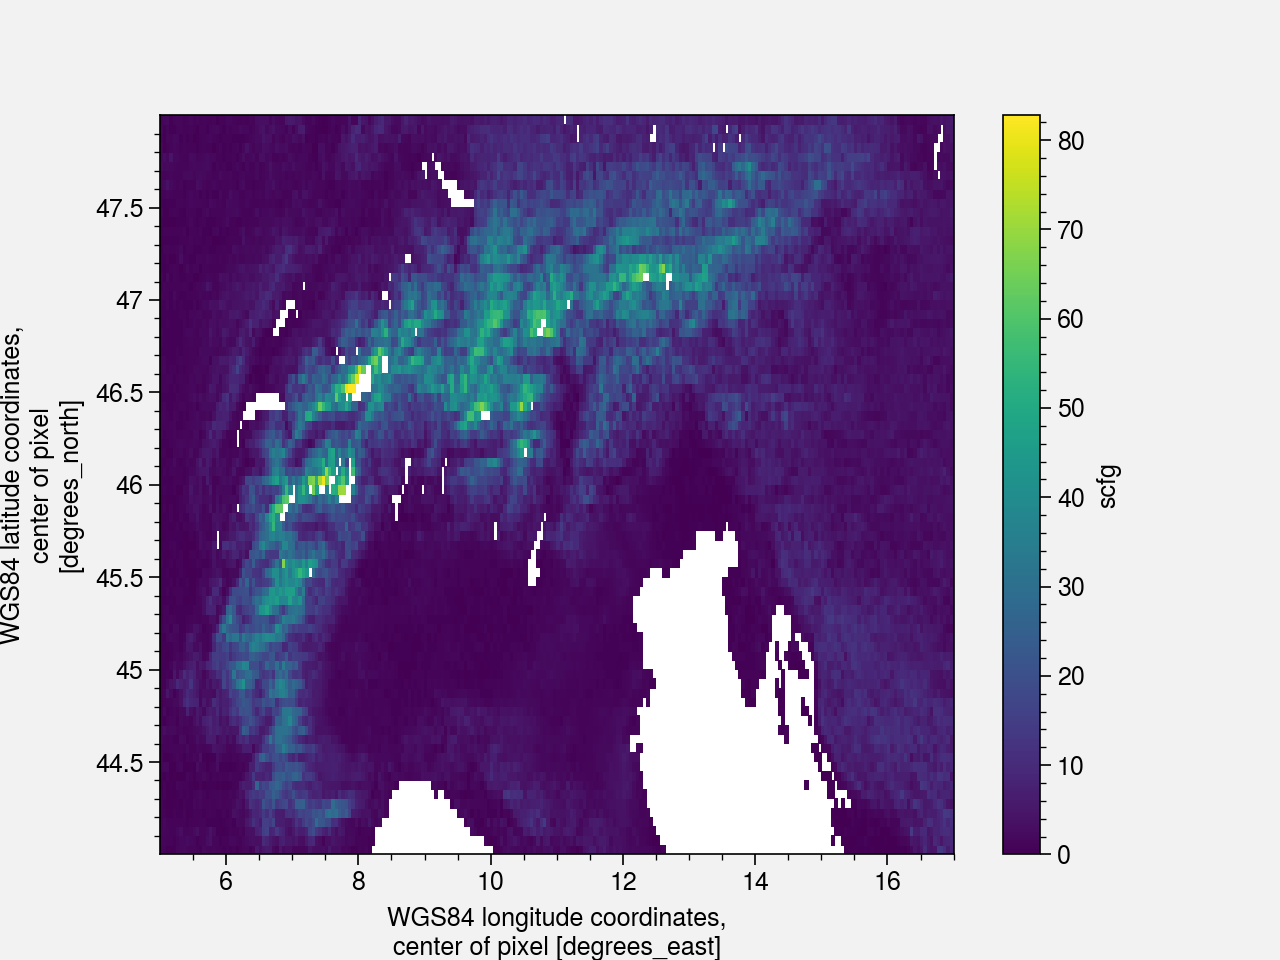

In [9]:
scf.mean('time').plot()

In [10]:
# Check data availability
data_coverage = ((scf.count('time') / scf.time.size)*100).load()

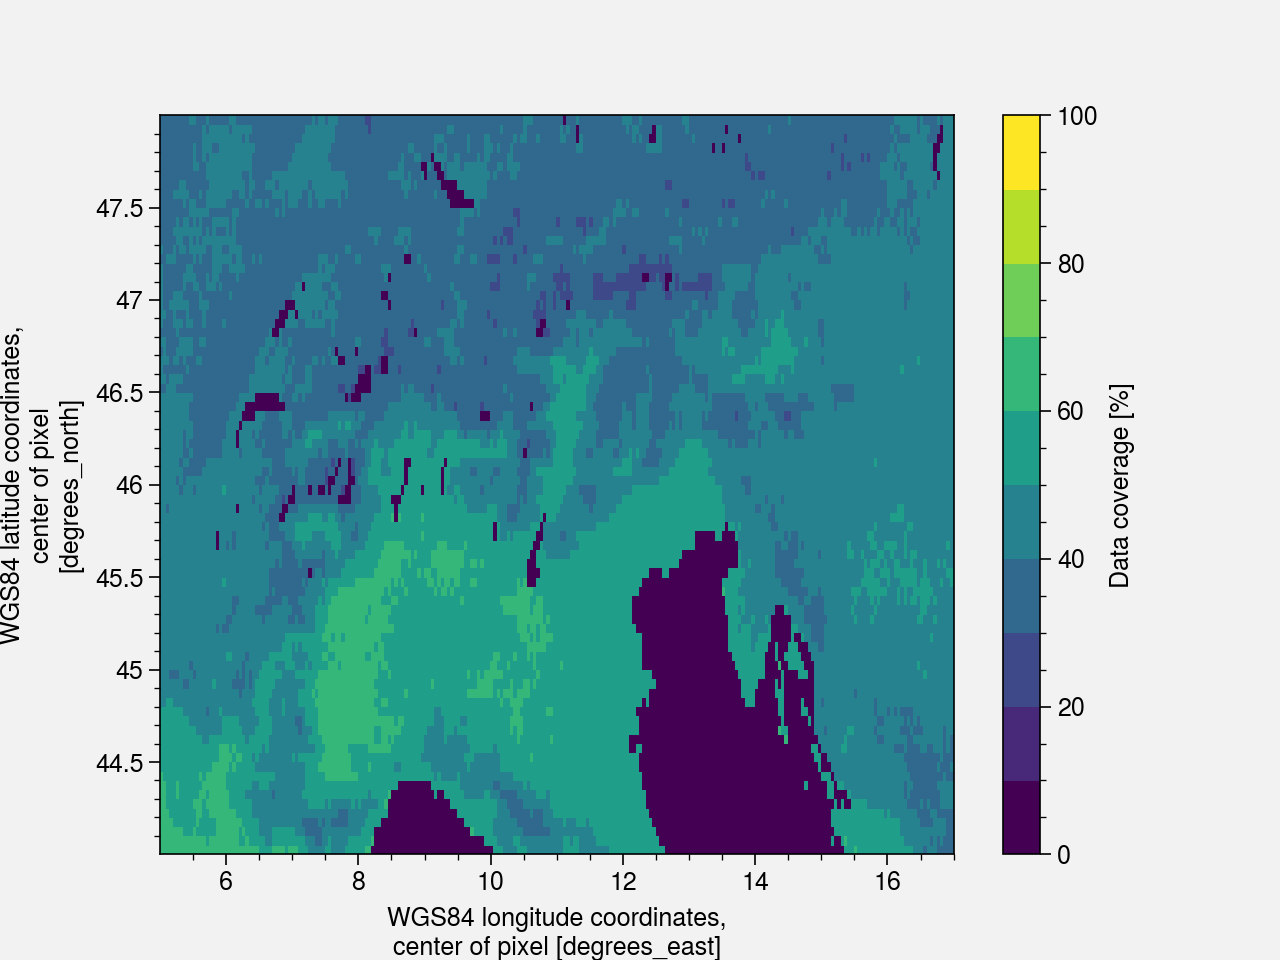

In [11]:
data_coverage.name = 'Data coverage'
data_coverage.attrs['units'] = '%'
data_coverage.plot(levels=plot.arange(0, 100, 10))

# NETCDF File information

scfg:_FillValue = 255UB;

scfg:long_name = "Snow Cover Fraction on Ground" ;

scfg:units = "percent" ;

scfg:standard_name = "surface_snow_area_fraction" ;

scfg:valid_range = 0UB, 254UB ;

scfg:actual_range = 0UB, 100UB ;

scfg:flag_values = 205UB, 206UB, 210UB, 215UB, 254UB ;

scfg:flag_meanings = "Cloud Polar_Night_or_Night Water Permanent_Snow_and_Ice No_Satellite_Acquisition" ;

scfg:grid_mapping = "spatial_ref" ;

scfg:ancillary_variables = "scfg_unc" ;

scfg:missing_value = 255UB ;

In [12]:
MV_cloud=ds_alps.scfg.where(ds_alps.scfg == 205).count(dim='time').load()

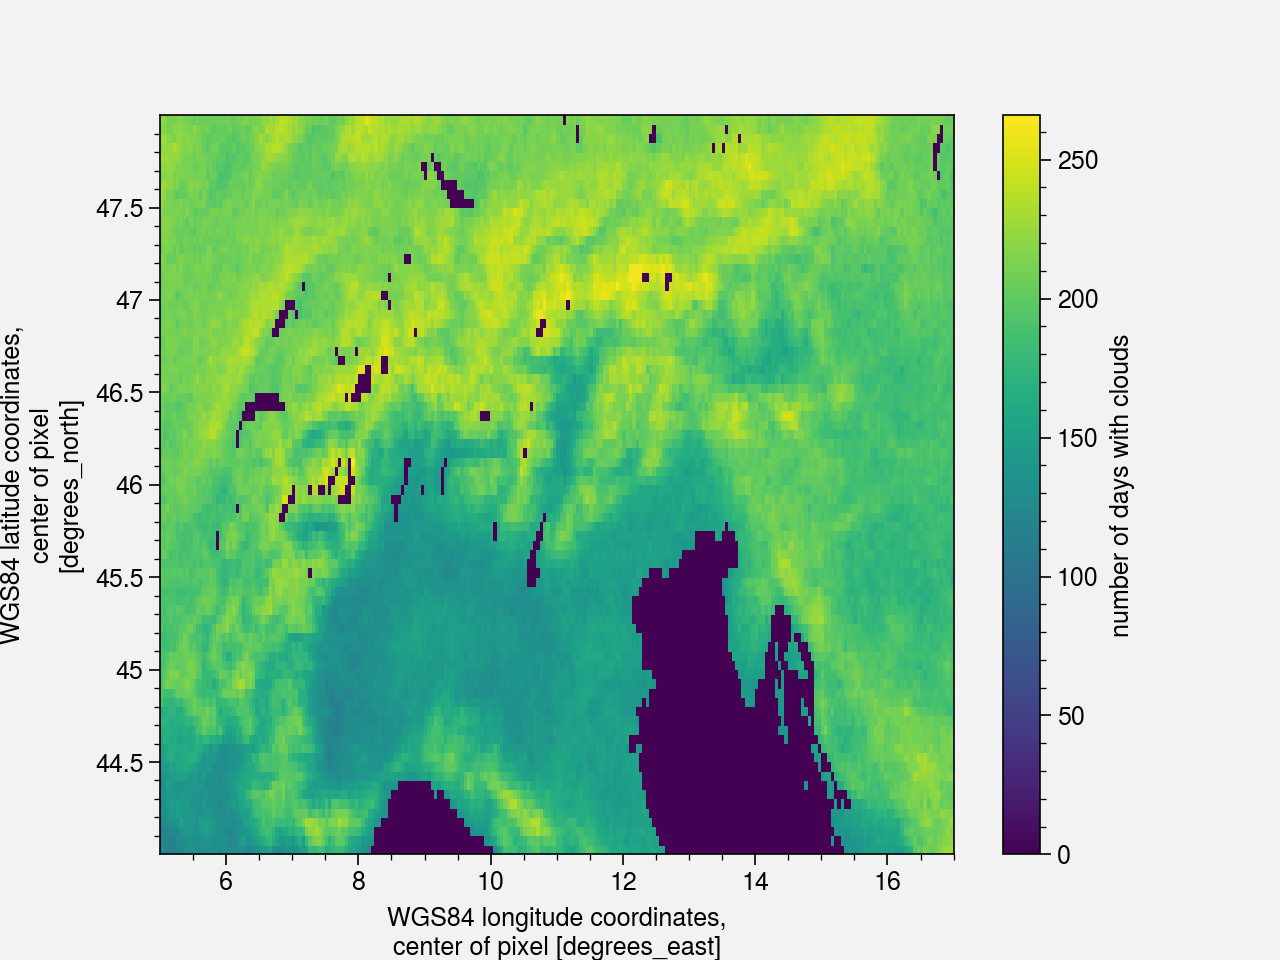

In [13]:
MV_cloud.name = 'number of days with clouds'
MV_cloud.plot()

In [14]:
scf_subset=scf.sel(time=slice('2001-01','2001-03'))
#scf_subset

In [15]:
import bottleneck as bn
max_gap=pd.Timedelta(days=10) # Maximum period lenght with missing value considered for gap filling

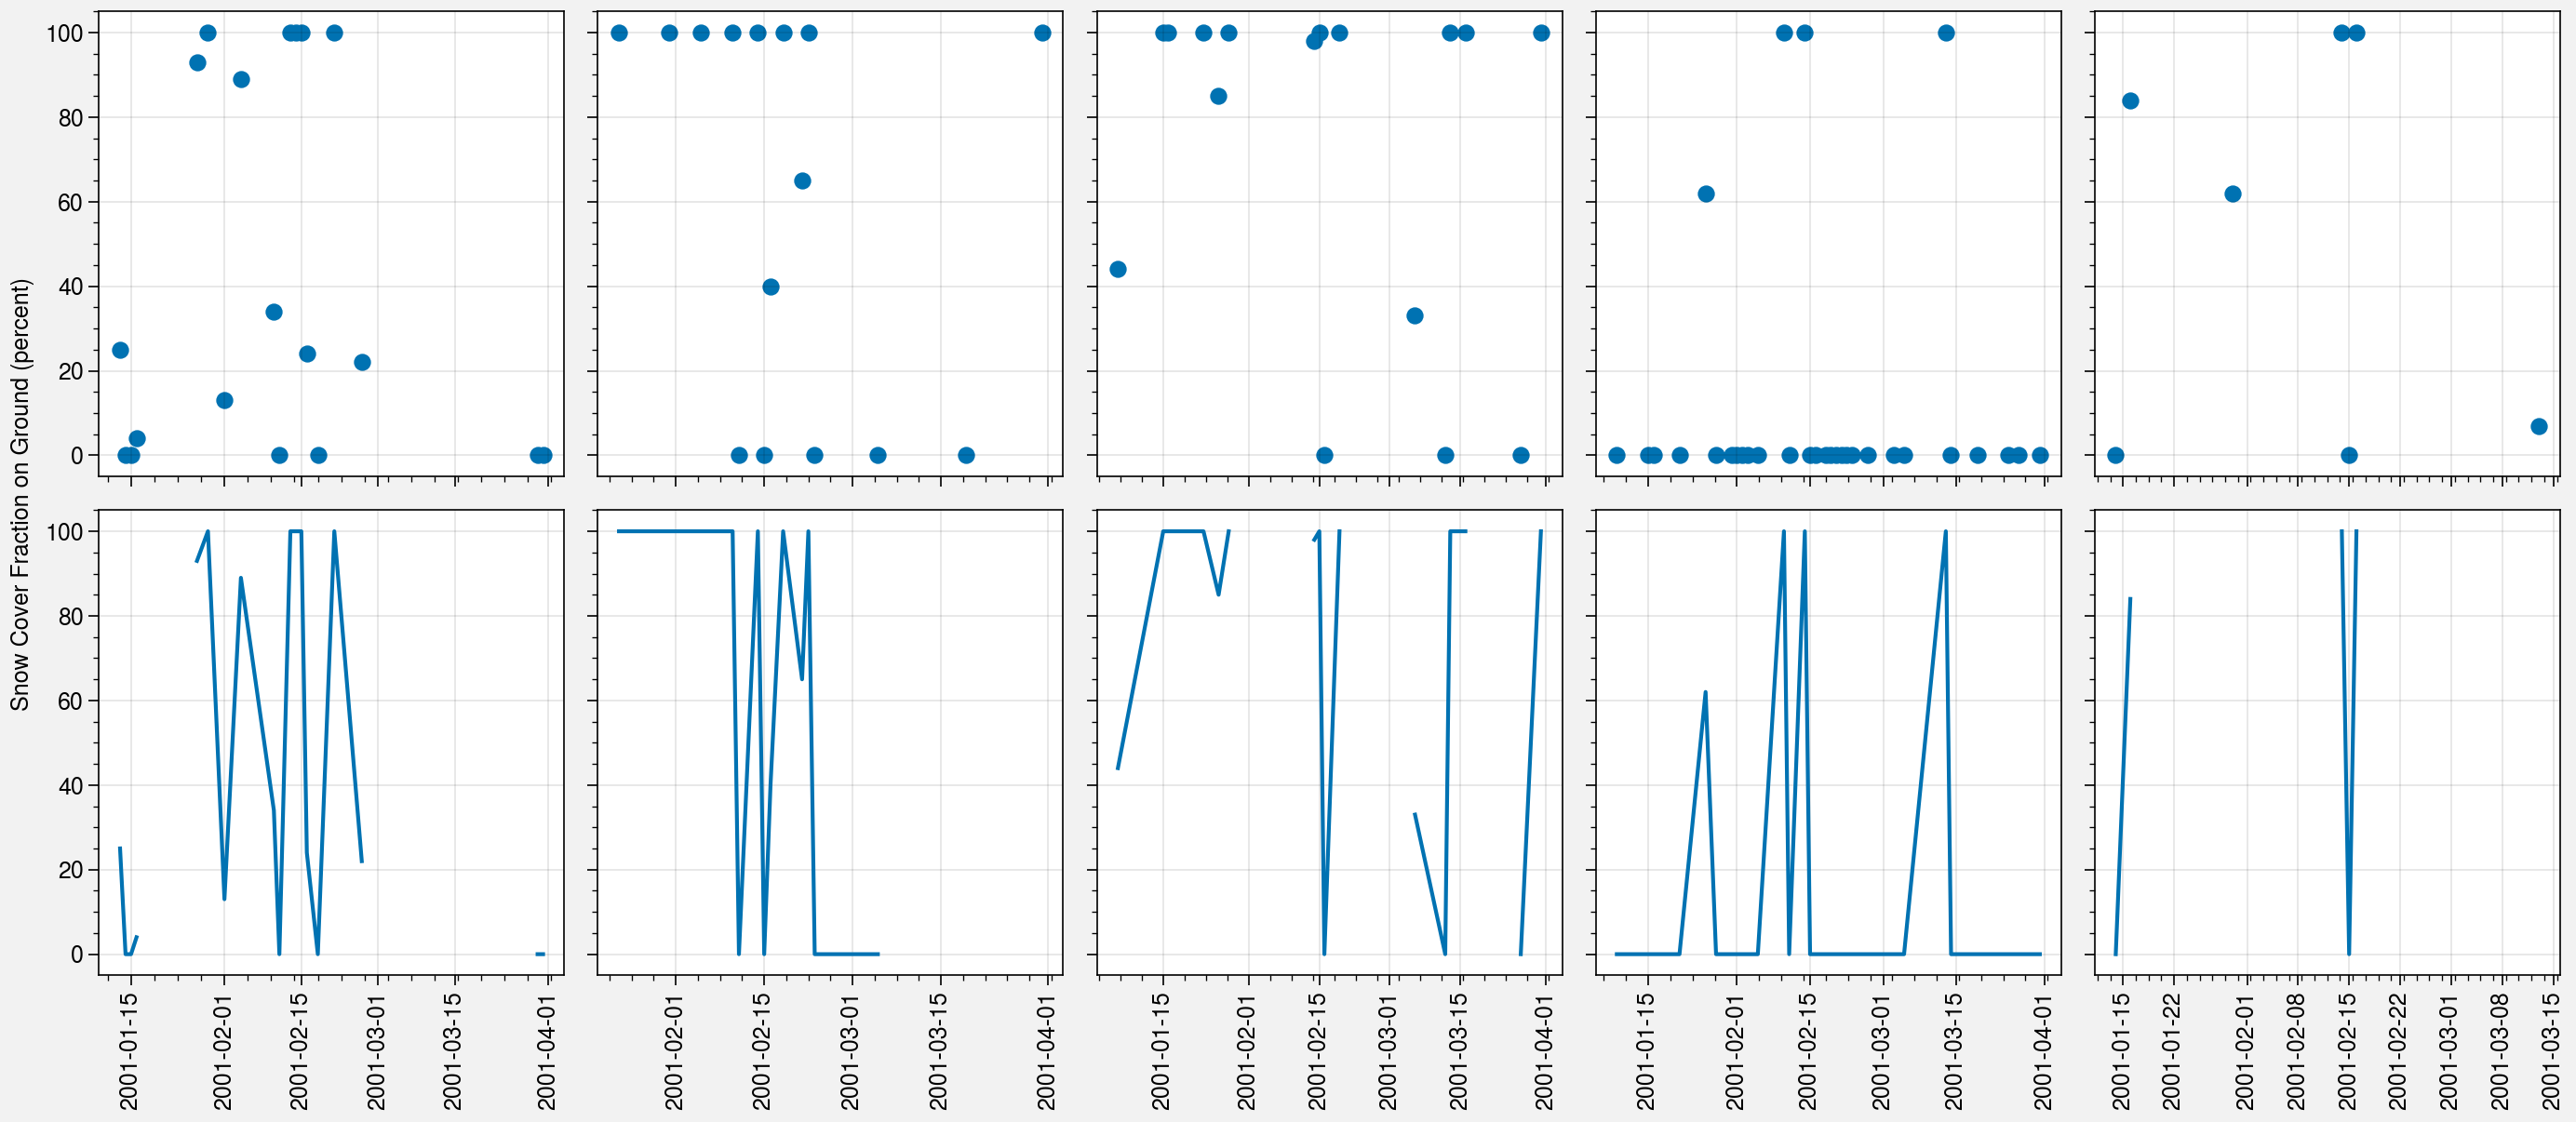

In [16]:
# Test gapfilling with interpolate_na on some gridpoints:
latlons = [[46, 7], [46, 10], [47, 10], [46, 11], [47, 11]]

fig, axs = plot.subplots(nrows=2, ncols=len(latlons))

for i, latlon in enumerate(latlons):
    axs[0, i].scatter(scf_subset.time.values, scf_subset.sel(lon=latlon[1], lat=latlon[0], method='nearest'))
    axs[1, i].plot(scf_subset.sel(lon=latlon[1], lat=latlon[0], method='nearest').interpolate_na('time', method='linear',max_gap=max_gap))   

In [17]:
# Gap filling

In [18]:
scf_time_interp = scf.chunk({'time': -1}).interpolate_na('time', method='linear',max_gap=max_gap)
scf_time_interp

<xarray.DataArray 'scfg' (time: 365, lat: 80, lon: 240)>
dask.array<where, shape=(365, 80, 240), dtype=float64, chunksize=(365, 80, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 44.03 44.08 44.12 44.17 ... 47.83 47.88 47.92 47.97
  * lon      (lon) float64 5.025 5.075 5.125 5.175 ... 16.83 16.88 16.92 16.98
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [210 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [19]:
scf_interp = scf_time_interp.where(scf_time_interp <= 100)
data_coverage_interp = ((scf_interp.count('time') / scf_interp.time.size)*100).load()

In [20]:
data_coverage_interp.name = 'Data coverage'
data_coverage_interp.attrs['units'] = '%'

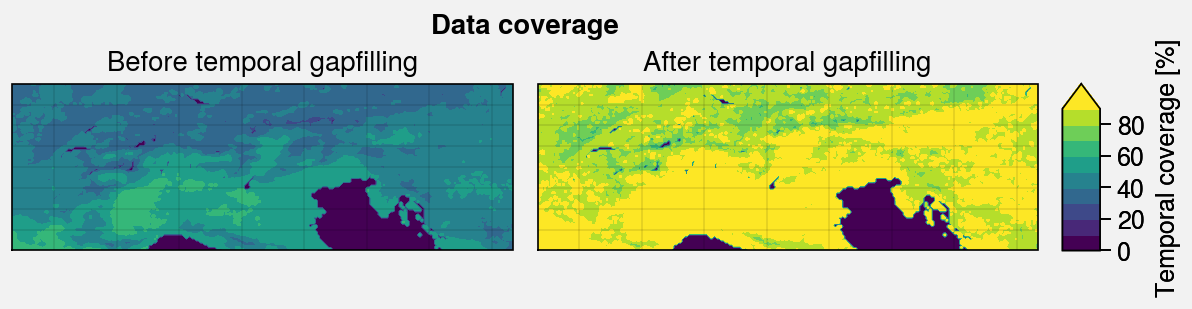

In [21]:
fig, axs = plot.subplots(ncols=2, proj='cyl')

levels = plot.arange(0, 90, 10)
extend = 'max'
cmap='viridis'

m = axs[0].contourf(data_coverage, levels=levels, extend=extend, cmap=cmap)
axs[1].contourf(data_coverage_interp, levels=levels, extend=extend, cmap=cmap)

fig.colorbar(m, label='Temporal coverage [%]')

for title, ax in zip(['Before temporal gapfilling', 'After temporal gapfilling'], axs):
    ax.format(title=title)
    
axs.format(
    suptitle='Data coverage',
    latlim=(latlim_ext.start, latlim_ext.stop), lonlim=(lonlim_ext.start, lonlim_ext.stop)
)

In [22]:
scf_monthly_interp = scf_interp.groupby('time.month').mean('time').load()

/home/mmenegoz/.conda/envs/martin_2021/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [23]:
scf_monthly_interp.month

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

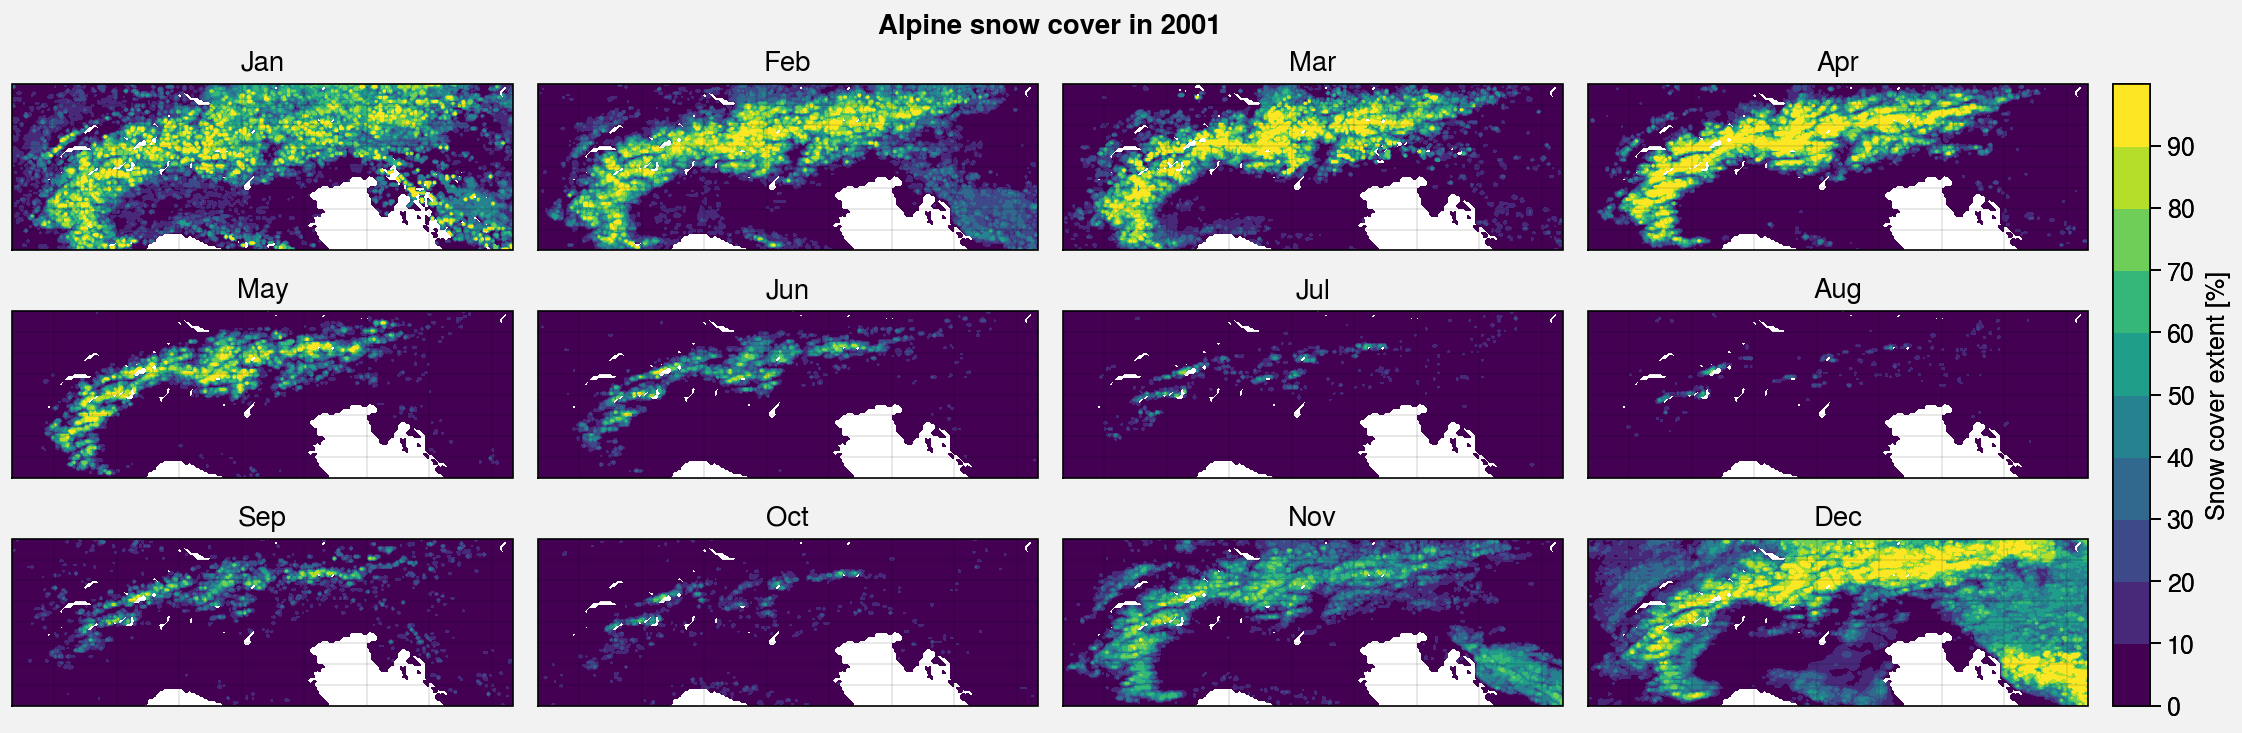

In [24]:
fig, axs = plot.subplots(ncols=4,nrows=3, proj='cyl')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
levels = plot.arange(0, 90, 10)
extend = 'max'
cmap='viridis'

for i, ax in enumerate(axs):
        m = ax.contourf(
            scf_monthly_interp.sel(month=scf_monthly_interp.month[i]), cmap=cmap, 
            levels=levels, extend=extend),
        ax.format(title=months[i],
        latlim=(latlim_ext.start, latlim_ext.stop), lonlim=(lonlim_ext.start, lonlim_ext.stop)
        )

axs.format(suptitle="Alpine snow cover in 2001")
fig.colorbar(m, label='Snow cover extent [%]')

In [26]:
# To do list:
# O. When the data is already downloaded, skip the extraction step and download a netcdf file
# 1. Compute the number of missing values (percentage during the full period)
# 2. Fill the gaps
# 3. Compute and plot the monthly means
# 4. Compute the trends over the full period
# 5. Apply the script to Pyrenees and Atlas mountains
# 6. Coarsen the grid to 25 and 50 km for comparisons with LMDZ (python function coarsen)